In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statistics

np.random.seed(42)

# Create dataframes from csv
table3 = pd.read_csv("./table3.csv")
table4 = pd.read_csv("./table4.csv")

# Assignment 9

## 9.1 
Formulate interesting hypotheses, based on table3 and 4 and perform an analysis. The assumption for this assignment is that
the analysis should be interesting and relevant from the perspective of publishing a paper at an
international conference.

**Hypothesis 0 (H<sub>0</sub>)**: Students with at least some industrial experience in general programming produce the same number of errors per KLOC as students with less experience.  
**Hypothesis 1 (H<sub>1</sub>)**: Students with at least some industrial experience in general progamming produces fewer errors per KLOC than students with less experience.

### Method explained

The first step is to create separate datasets from Table3 and Table4 with the correct data.

In [428]:
# Get subjects with "some industrial experience" or more from Table 3
subjects_with_exp = table3[table3["Prog."] > 2]

# Get subjects with less than "some industrial experience" from Table 3
subjects_with_less_exp = table3[table3["Prog."] < 3]

# Get subjects from Table 4 where the subject value is in subject_with_exp
subjects_with_exp_result = table4[table4["Subject"].isin(subjects_with_exp["Subject"])]

# Get subjects from Table 4 where the subject value is in subject_with_less_exp
subjects_with_less_exp_result = table4[table4["Subject"].isin(subjects_with_less_exp["Subject"])]

With the two datasets **subjects_with_exp_result** and **subjects_with_less_exp_result**, I can compare the difference on the column with the data of interest, the column **Faults/ KLOC**. First, I use Shapiro-Wilks to find if the data is normal distributed or not.

In [429]:
print(f"Subjects with more experience: {stats.shapiro(subjects_with_exp_result).pvalue}")
print(f"Subjects with less experience: {stats.shapiro(subjects_with_less_exp_result).pvalue}")

Subjects with more experience: 3.762094430225854e-22
Subjects with less experience: 1.1335907310244518e-26


Shapiro-Wilks resulted in very low p-values for both datasets and both follows a normal distribution. The data is continuous, normal distributed and only two groups, so I chose to use T-test to measure the difference. The null hypothesis for the T test is that there is no significant difference between the measured mean values. The alpha is 0.05.

In [432]:
t_stat, p_value = stats.ttest_ind(subjects_with_exp_result["Faults/ KLOC"], subjects_with_less_exp_result["Faults/ KLOC"])
p_value

0.5903350518612702

The result shows a p-value larger than 0.05 and H0 is not rejected and there are not a significant difference between the datasets. To further analyze the data I plotted boxplots to see visualize the spread of the data.

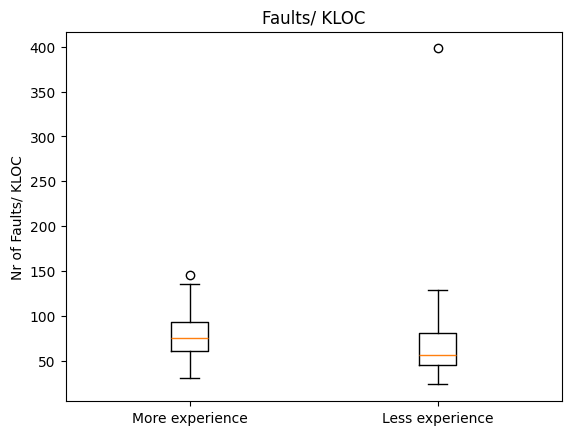

In [434]:
# Plot boxplot to visualize the mean and spread around the mean
data = [subjects_with_exp_result["Faults/ KLOC"], subjects_with_less_exp_result["Faults/ KLOC"]]
plt.boxplot(data, labels=["More experience", "Less experience"])
plt.title("Faults/ KLOC")
plt.ylabel('Nr of Faults/ KLOC')
plt.show()

From the boxplot above it is clear that the median is slightly higher than in the more experienced group than in the less experienced group, meaning the more experiences group produces slightly more faults per KLOC, but not significantly more, since the p-value is higher than 0.05 in the previous test.

All tests indicates that there are no significant difference between the subjects in regard to the produced number of faults per KLOC between subjects with less experience and subjects with more experience. 

## 9.2
**Step 1**: Perform Bayesian hypothesis tests of the hypotheses formulated or inferred during step 1. Divide the data in each table into two sets by random sampling without replacement. Let one set from each table represent Empirical Data Batch 1 and let the other set from each table represent Empirical Data Batch 2.  

To create the batches, I first shuffled the dataframes. Since the row count were not the same for the datasets (24 and 35), I undersampled 12 rows from the dataset with more than 12 rows. This means that I reduced the dataset to match the one with the least amount of rows.

In [477]:
# First I split the dataframe in half by sampling 50% without replacement
subjects_with_exp_1 = subjects_with_exp_result.sample(frac=0.5, replace=False, random_state=42)
subjects_with_less_exp_1 = subjects_with_less_exp_result.sample(frac=0.5, replace=False, random_state=42)

# Next step is to extract the second part by removing the first set from the original
subjects_with_exp_2 = subjects_with_exp_result.drop(subjects_with_exp_1.index)
subjects_with_less_exp_2 = subjects_with_less_exp_result.drop(subjects_with_less_exp_1.index)

# Take first 12 rows from the datasets with "less experience" 
subjects_with_less_exp_1 = subjects_with_less_exp_result.iloc[0:12]
subjects_with_less_exp_2 = subjects_with_less_exp_result.iloc[0:12]

# Create the batches
empirical_data_batch_1 = (subjects_with_exp_1, subjects_with_less_exp_1)
empirical_data_batch_2 = (subjects_with_exp_2, subjects_with_less_exp_2)

**Step 2**: Assign (subjective) a priori probabilities that the formulated hypotheses (the null hypothesis and alternative hypothesis/hypotheses for each table) from experience or by using the lottery approach.

Here, I chose to use the resulting p-value from the T-test conducted in 9.1. The result was a p-value of 0.59 (0.6).

In [478]:
# Assign a priori probability to the null hypothesis and the alternative hypothesis
PH0 = 0.6 # There is no difference
PH1 = 0.4 # There is a difference

**Step 3**: Compute a posteriori probabilities by using Empirical Data Batch 1 and the a priori probabilities.  

Since the data is continuous and normal distrubuted, I used likelihood calculation with a probability density function in scipy.stats.norm package. The result is lists of probabilities adding up to 1 for each probability in h0 and h1. To get the posterior probability, I took the mean value for each result. A lot of the functionality is taken from [1].

In [481]:
from scipy.stats import norm

def compute_posterior_probs(data, p_h0, p_h1): 
    # Calculate likelihoods
    likelihood_H0 = norm.pdf(data[0]["Faults/ KLOC"], loc=p_h0, scale=data[0]["Faults/ KLOC"].std())
    likelihood_H1 = norm.pdf(data[1]["Faults/ KLOC"], loc=p_h1, scale=data[1]["Faults/ KLOC"].std())
    
    # Calculate marginal probability
    P_E = likelihood_H0 * p_h0 + likelihood_H1 * p_h1
    
    # Calculate posterior probabilities
    posterior_H0 = (likelihood_H0 * p_h0) / P_E
    posterior_H1 = (likelihood_H1 * p_h1) / P_E

    return (posterior_H0, posterior_H1)

# Call the function using bath 1 and the priori probabilities
h0, h1 = compute_posterior_probs(empirical_data_batch_1, PH0, PH1)
h0_result = h0.mean()
h1_result = h1.mean()
print("Posterior probabilities for H0:", h0_result)
print("Posterior probabilities for H1:", h1_result)

Posterior probabilities for H0: 0.4737897585678576
Posterior probabilities for H1: 0.5262102414321425


The calculation results in the posterior probability ~0.47 for H0 and ~0.52 for H1. The probabilities are lower for H0 than the result from the T-test (0.59). 

**Step 5**: Use the resulting probabilities as a priori probabilities and, again, compute a posteriori probabilities but now by using Empirical Data Batch 2.  

Here I reused the function *computePosteriorProbs* with the posterior probabilities as prior probablities.

In [482]:
h0, h1 = compute_posterior_probs(empirical_data_batch_2, h0_result, h1_result)

print("Posterior probabilities for H0:", h0.mean())
print("Posterior probabilities for H1:", h1.mean())

Posterior probabilities for H0: 0.26283639761110084
Posterior probabilities for H1: 0.7371636023888991


The result shows that the support for H1 is much stronger than before, 0.74 (74%), when adding more evidence to the calculation. This in turn indicates that there is a higher probability that there are difference in faults per KLOC between students with more experience and students with less experience. To futher see of that claim is correct, I checked the correlation between the subjects programming experience and the faults per KLOC.

In [315]:
merged = table4.merge(table3[["Subject", "Prog."]], on="Subject", how="left")
merged[["Prog.",'Faults/ KLOC']].corr()

,Prog.,Faults/ KLOC
Prog.,1.000000,0.103986
Faults/ KLOC,0.103986,1.000000


The correlation is positive, 0.10, and supports the claim that there are a difference and students with more experience produces ~10% more faults per KLOC than students with less prior experience. 

## References

[1] P. Martins de Bastos, (Jun 2022), “How to use Bayesian Inference for predictions in Python”. Accessed on: Nov. 26, 2024. [Online]. Available: https://towardsdatascience.com/how-to-use-bayesian-inference-for-predictions-in-python-4de5d0bc84f3


